In [4]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math, copy, time
from torch.autograd import Variable
import matplotlib.pyplot as plt
import seaborn
seaborn.set_context(context='talk')
%matplotlib inline

standard Encoder-Decoder architecture

In [5]:
class EncoderDecoder(nn.Module):
    def __init__(self,encoder,decoder, src_embed, tgt_embed, generator):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.generator = generator
        
    def forward(self, src, tgt, src_mask, tgt_mask):
        return self.decode(self.encode(src,src_mask),src_mask,
                           tgt,tgt_mask)
    
    def encode(self, src, src_mask):
        return self.encoder(self.src_embed(src),src_mask)
    
    def decode(self, memory, src_mask, tgt, tgt_mask):
        return self.decoder(self.tgt_embed(tgt),memory, src_mask, tgt_mask)


Define standard linear + softmax generation step

In [6]:
class Generator(nn.Module):
    def __init__(self, d_model, vocab):
        super(Generator, self).__init__()
        self.proj = nn.Linear(d_model, vocab)
    
    def forward(self,x):
        return F.log_softmax(self.proj(x), dim=-1)

make composed of a stack of  identical layers

In [7]:
def clones(module, N):
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

Core encoder is a stack of layers 

In [8]:
class Encoder(nn.Module):
    def __init__(self,layer,N):
        super(Encoder,self).__init__()
        self.layers = clones(layer,N)
        self.norm = LayerNorm(layer.size)
    
    def forward(self,x,mask):
        for layer in self.layers:
            x = layer(x,mask)
        return self.norm(x)

layer normalization

In [9]:
class LayerNorm(nn.Module):
    def __init__(self, features, eps=1e-6):
        super(LayerNorm,self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps
    
    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2

In [10]:
x = torch.tensor([1,2,3,4,6,8],dtype=torch.float32)
x

tensor([1., 2., 3., 4., 6., 8.])

In [11]:
x.mean(-1,keepdim=True)

tensor([4.])

In [12]:
x.std(-1,keepdim= True)

tensor([2.6077])

A residual connection followed by a layer norm.<br>
Note for code simplicity the norm is first as opposed to last.

In [13]:
class SublayerConnection(nn.Module):
    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self,x,sublayer):
        return x + self.dropout(sublayer(self.norm(x)))

Encoder is made up of self-attn and feed forward (defined below)

In [14]:
class EncoderLayer(nn.Module):
    def __init__(self,size,self_attn, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size,dropout),2)
        self.size = size
        self.dropout = nn.Dropout(dropout)
        
    def forward(self,x,mask):
        x = self.sublayer[0](x,lambda x:self.self_attn(x,x,x,mask))
        return self.sublayer[1](x,self.feed_forward)
    

"Generic N layer decoder with masking."

In [15]:
class Decoder(nn.Module):
    def __init__(self, layer, N):
        super(Decoder, self).__init__()
        self.layers = clones(layer,N)
        self.norm = LayerNorm(layer.size)
    
    def forward(self, x, memory, src_mask, tgt_mask):
        for layer in self.layers:
            x = layer(x, memory, src_mask, tgt_mask)
        return self.norm(x)

Decoder is made of self-attn, src-attn, and feed forward (defined below

In [16]:
class DecoderLayer(nn.Module):
    def __init__(self,size,self_attn, src_attn, feed_forward,dropout):
        super(DecoderLayer, self).__init__()
        self.size = size
        self.self_attn = self_attn
        self.src_attn = src_attn
        self.dropout = nn.Dropout(dropout)
        self.sublayer = clones(SublayerConnection(size,dropout),3)
        self.feed_forward = feed_forward
        
    def forward(self,x, memory, src_mask, tgt_mask):
        m = memory
        x = self.sublayer[0](x, lambda x:self.self_attn(x,x,x,tgt_mask))
        x = self.sublayer[1](x, lambda x:self.src_attn(x,m,m,src_mask))
        return self.sublayer[2](x, self.feed_forward)

#### modify the self-attention sub-layer in the decoder stack to prevent positions from attending to subsequent positions. <br>
This masking, combined with fact that the output embeddings are offset by one position, <br>
ensures that the predictions for position i can depend only on the known outputs at positions less than i
.

In [17]:
def subsequent_mask(size):
    attn_shape = (1,size,size)
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
    return torch.from_numpy(subsequent_mask) == 0

In [18]:
a = np.array([[1,2,3],[4,5,6],[7,8,9],[10,11,12]])

In [19]:
print(np.triu(a,k=0),'\n','------------')
print(np.triu(a,k=1))

[[1 2 3]
 [0 5 6]
 [0 0 9]
 [0 0 0]] 
 ------------
[[0 2 3]
 [0 0 6]
 [0 0 0]
 [0 0 0]]


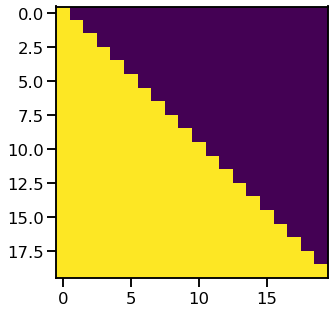

In [20]:
plt.figure(figsize=(5,5))
plt.imshow(subsequent_mask(20)[0])
None

### compute scaled dot-product attention

In [21]:
def attention(query, key, value, mask=None, dropout=None):
    "Compute 'Scaled Dot Product Attention'"
    d_k = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2, -1)) \
             / math.sqrt(d_k)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
    p_attn = F.softmax(scores, dim = -1)
    if dropout is not None:
        p_attn = dropout(p_attn)
    return torch.matmul(p_attn, value), p_attn

### tenser.masked_fill

In [22]:
a=torch.tensor([[[5,5,5,5], [6,6,6,6], [7,7,7,7]], 
                [[1,1,1,1],[2,2,2,2],[3,3,3,3]]])
print(a)
print("------------------------")
mask = torch.BoolTensor([[[1],[1],[0]],
                         [[0],[1],[1]]])
# mask==1 is default
b = a.masked_fill(mask, value=torch.tensor(-1e9))
print(b)
print('a.size={}, mask.size={}'.format(a.size(),mask.size()))

tensor([[[5, 5, 5, 5],
         [6, 6, 6, 6],
         [7, 7, 7, 7]],

        [[1, 1, 1, 1],
         [2, 2, 2, 2],
         [3, 3, 3, 3]]])
------------------------
tensor([[[-1000000000, -1000000000, -1000000000, -1000000000],
         [-1000000000, -1000000000, -1000000000, -1000000000],
         [          7,           7,           7,           7]],

        [[          1,           1,           1,           1],
         [-1000000000, -1000000000, -1000000000, -1000000000],
         [-1000000000, -1000000000, -1000000000, -1000000000]]])
a.size=torch.Size([2, 3, 4]), mask.size=torch.Size([2, 3, 1])


In [23]:
class MultiHeadedAttention(nn.Module):
    def __init__(self,h, d_model, dropout=0.1):
        super(MultiHeadedAttention,self).__init__()
        # by default
        # d_model = 512
        # h = 8
        # thus, d_k = 512/8 = 64
        # also d_v is identical to d_k
        assert d_model % h == 0
        #assume d_v always equals to d_k
        self.d_k = d_model // h
        self.h = h 
        self.linears = clones(nn.Linear(d_model,d_model),4)
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)
    
    def forward(self, query, key, value, mask=None):
        if mask is not None:
            # same mask applys to all heads
            # unsqueenze: add a dim in dim=1
            mask = mask.unsqueeze(1)
        nbatches = query.size(0)
        # 1) Do all the projections in batch from d_model to h * d_k 
        query, key, value = \
        [func(x).view(nbatches,-1,self.h,self.d_k).transpose(1,2) 
         for func, x in zip(self.linears, (query, key, value))]
        # 2) Apply attention on all the projected vectors in batch. 
        x, self.attn = attention(query, key, value, mask=mask,
                                 dropout=self.dropout)
        # 3) "Concat" using a view and apply a final linear. 
        x = x.transpose(1,2).contiguous().view(nbatches, 
                                               -1, self.h * self.d_k)
    
        return self.linears[-1](x)

In [24]:
x = torch.tensor(np.ones((2,512)))
x.size()

torch.Size([2, 512])

In [25]:
x = x.view(2,-1,8,8).transpose(1,2)
x.size()

torch.Size([2, 8, 8, 8])

### Position-wise Feed Forward Networks

In [26]:
class PositionwiseFeedForward(nn.Module):
    # FNN  equation
    def __init__(self, d_model, d_ff, dropout=0.1):
        # by default
        # d_model = 512
        # d_ff = 2048
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model,d_ff)
        self.w_2 = nn.Linear(d_ff,d_model)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self,x):
        return self.w_2(self.dropout(F.relu(self.w_1(x))))
    

In [27]:
class Embeddings(nn.Module):
    def __init__(self, d_model, vocab):
        super(Embeddings, self).__init__()
        self.lut = nn.Embedding(vocab,d_model)
        self.d_model = d_model
        
    def forward(self, x):
        return self.lut(x) * math.sqrt(self.d_model)

### Positional Encoding

In [28]:
class PositionalEncoding(nn.Module):
    def __init__(self,d_model, dropout, max_len = 5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(dropout)
        pe = torch.zeros(max_len,d_model)
        position = torch.arange(0,max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * 
                            -(math.log(10000.0) / d_model))
        pe[:,0::2] = torch.sin(position * div_term)
        pe[:,1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe',pe)
        
    def forward(self,x):
        x = x + Variable(self.pe[:,:x.size(1)],
                        requires_grad=False)
        return self.dropout(x)

In [29]:
d_m = 512
pos = torch.arange(0, d_m, 2)[:10]
print(pos)
div_term = torch.exp(pos * -(math.log(10000.0) / d_m))

tensor([ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18])


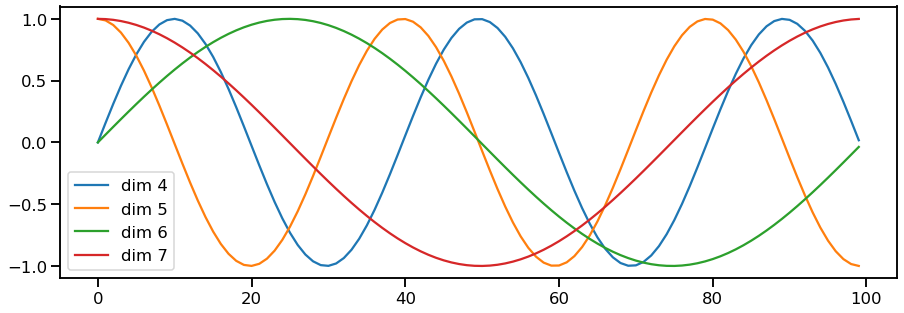

In [30]:
plt.figure(figsize=(15, 5))
pe = PositionalEncoding(20, 0)
y = pe.forward(Variable(torch.zeros(1, 100, 20)))
plt.plot(np.arange(100), y[0, :, 4:8].data.numpy())
plt.legend(["dim %d"%p for p in [4,5,6,7]])
None

### Full Model Creation

In [31]:
def make_model(src_vocab, tgt_vocab, N=6, 
              d_model=512, d_ff=2048, h=8, dropout=0.1):
    # build model with hyperpara
    c = copy.deepcopy
    attn = MultiHeadedAttention(h, d_model)
    ff = PositionwiseFeedForward(d_model, d_ff, dropout)
    position = PositionalEncoding(d_model, dropout)
    model = EncoderDecoder(
        Encoder(EncoderLayer(d_model,c(attn),c(ff),dropout),N),
        Decoder(DecoderLayer(d_model,c(attn),
                             c(attn),c(ff),dropout),N),
        nn.Sequential(Embeddings(d_model,src_vocab),c(position)),
        nn.Sequential(Embeddings(d_model,tgt_vocab),c(position)),
        Generator(d_model,tgt_vocab)
    )
    # This was important from their code. 
    # Initialize parameters with Glorot / fan_avg.
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)
    return model

### Batches and Masking

In [32]:
class Batch:
    "Object for holding a batch of data with mask during training."
    def __init__(self, src, trg=None, pad=0):
        self.src = src
        self.src_mask = (src != pad).unsqueeze(-2)
        if trg is not None:
            self.trg = trg[:, :-1]
            self.trg_y = trg[:, 1:]
            self.trg_mask = \
                self.make_std_mask(self.trg, pad)
            self.ntokens = (self.trg_y != pad).data.sum()
    
    @staticmethod
    def make_std_mask(tgt, pad):
        "Create a mask to hide padding and future words."
        tgt_mask = (tgt != pad).unsqueeze(-2)
        tgt_mask = tgt_mask & Variable(
            subsequent_mask(tgt.size(-1)).type_as(tgt_mask.data))
        return tgt_mask

### Training Loop

In [33]:
def run_epoch(data_iter, model, loss_compute):
    "Standard Training and Logging Function"
    start = time.time()
    total_tokens = 0
    total_loss = 0
    tokens = 0
    for i, batch in enumerate(data_iter):
        out = model.forward(batch.src, batch.trg, 
                            batch.src_mask, batch.trg_mask)
        loss = loss_compute(out, batch.trg_y, batch.ntokens)
        total_loss += loss
        total_tokens += batch.ntokens
        tokens += batch.ntokens
        if i % 50 == 1:
            elapsed = time.time() - start
            print("Epoch Step: %d Loss: %f Tokens per Sec: %f" %
                    (i, loss / batch.ntokens, tokens / elapsed))
            start = time.time()
            tokens = 0
    return total_loss / total_tokens

In [34]:
def run_epoch1(data_iter,model,loss_compute):
    # standard Training and loss logging
    start = time.time()
    total_tokens = 0
    total_loss = 0
    tokens = 0
    for i, batch in enumerate(data_iter):
        # trg_mask = Variable(subsequent_mask(bos_v.size(1)).type_as(src.data))
        out = model.forward(batch.src, batch.trg, 
                           batch.src_mask, batch.trg_mask)
        if (out.size(1)!=0):
            loss = loss_compute(out, batch.trg_y, batch.ntokens)
            total_loss += loss
            total_tokens += batch.ntokens
            tokens += batch.ntokens
        if i % 50 == 1:
            fout = out.contiguous().view(-1,x.size(-1))
            print(batch.src.shape)
            print(fout.shape)
            print(batch.trg.shape)
            print('src=',batch.src[0])
            print('out=',fout[0])
            print('tgt=',batch.trg[0])
            # print('trg-y=',batch.trg_y[0])
            if (out.size(1)!=0):
                prob = model.generator(out[:,-1])
                _, next_word = torch.max(prob, dim = 1)
                next_word = next_word.data[0]
                # print('out=',next_word)
                elapsed = time.time() - start
                print('Epoch step:{}  loss:{}  Token per Sec:{}'\
                      .format(i, loss/batch.ntokens, tokens/ elapsed))
                start = time.time()
                tokens = 0
    return total_loss / total_tokens

### Attribute of torchtext.data.iterator: 
  
  
  #### batch_size_fn: 
  
  Function of three arguments
  
  (new example to add, current count of examples in the batch, and current effective batch size)
  
  that returns the new effective batch size resulting from adding that example to a batch. This is useful for dynamic batching, where this function would add to the current effective batch size the number of tokens in the new example.

In [35]:
global max_src_in_batch, max_tgt_in_batch
def batch_size_fn(new, count, sofar):
    # keep augmenting batch and calculate total number of tokens + padding
    global max_src_in_batch, max_tgt_in_batch
    if count == 1:
        max_src_in_batch = 0
        max_tgt_in_batch = 0
    max_src_in_batch = max(max_src_in_batch, len(new.src))
    max_tgt_in_batch = max(max_tgt_in_batch, len(new.trg) + 2)
    src_elements = count * max_src_in_batch
    tgt_elements = count * max_tgt_in_batch
    return max(src_elements,tgt_elements)

# return the max dynamic size of the batch (not size of the step)

In [36]:
class NoamOpt:
    def __init__(self,model_size, factor, warmup, optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup =warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0
    
    def step(self):
        self._step += 1
        rate = self.rate()
        for p in self.optimizer.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()
    
    def rate(self, step=None):
        if step is None:
            step = self._step
        return self.factor * (self.model_size ** (-0.5) *
                              min(step**(-0.5), 
                                  step * self.warmup ** (-1.5)))
def get_std_opt(model):
    return NoamOpt(model.src_embed[0].d_model, 2 ,4000,
                  torch.optim.Adam(model.parameters(),
                                   lr=0,betas=(0.9,0.98),eps=1e-9))

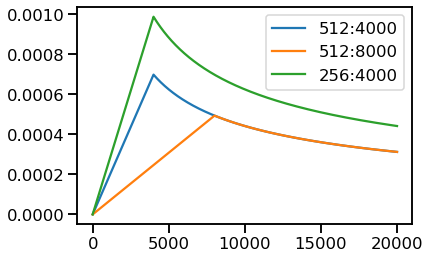

In [37]:
opts = [NoamOpt(512, 1, 4000, None), 
        NoamOpt(512, 1, 8000, None),
        NoamOpt(256, 1, 4000, None)]
plt.plot(np.arange(1, 20000), [[opt.rate(i) for opt in opts] for i in range(1, 20000)])
plt.legend(["512:4000", "512:8000", "256:4000"])
None

### Regularization

In [38]:
class LabelSmoothing(nn.Module):
    "Implement label smoothing."
    def __init__(self, size, padding_idx, smoothing=0.0):
        super(LabelSmoothing, self).__init__()
        self.criterion = nn.KLDivLoss(size_average=False)
        self.padding_idx = padding_idx
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.size = size
        self.true_dist = None
        
    def forward(self, x, target):
        assert x.size(1) == self.size
        true_dist = x.data.clone()
        true_dist.fill_(self.smoothing / (self.size - 2))
        true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        true_dist[:, self.padding_idx] = 0
        mask = torch.nonzero(target.data == self.padding_idx)
        if mask.dim() > 0:
            true_dist.index_fill_(0, mask.squeeze(), 0.0)
        self.true_dist = true_dist
        return self.criterion(x, Variable(true_dist, requires_grad=False))

In [39]:
n = torch.tensor([[0,0,0,1],[0,2,2,0],[1,0,0,0]])
mask = torch.nonzero(n)
mask

C:\Users\Hu Hang\.julia\conda\3\envs\deepl\lib\site-packages\ipykernel_launcher.py:2: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple) (Triggered internally at  ..\torch\csrc\utils\python_arg_parser.cpp:766.)
  


tensor([[0, 3],
        [1, 1],
        [1, 2],
        [2, 0]])

tensor([[0.0000, 0.1333, 0.6000, 0.1333, 0.1333],
        [0.0000, 0.6000, 0.1333, 0.1333, 0.1333],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]])


C:\Users\Hu Hang\.julia\conda\3\envs\deepl\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


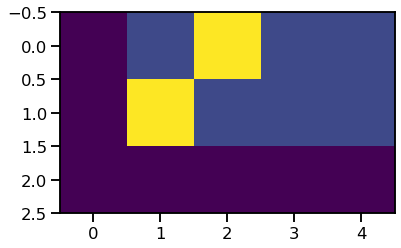

In [40]:
# Example of label smoothing.
crit = LabelSmoothing(5, 0, 0.4)
predict = torch.FloatTensor([[0, 0.2, 0.7, 0.1, 0],
                             [0, 0.2, 0.7, 0.1, 0], 
                             [0, 0.2, 0.7, 0.1, 0]])
v = crit(Variable(predict.log()), 
         Variable(torch.LongTensor([2, 1, 0])))

# Show the target distributions expected by the system.
print(crit.true_dist)
plt.imshow(crit.true_dist)
None

## ----------------------------------------------------------

### First Example

In [41]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [42]:
def data_gen(V, batch, nbatches):
    for i in range(nbatches):
        data = torch.from_numpy(np.random.randint(1, V, size=(batch,10)))
        data[:,0] = 1
        src = Variable(data.long(), requires_grad=False)
        src.to(device)
        tgt = Variable(data.long(), requires_grad=False)
        tgt.to(device)
        yield Batch(src,tgt,0)

In [43]:
class SimpleLossCompute:
    "A simple loss compute and train function."
    def __init__(self, generator, criterion, opt=None):
        self.generator = generator
        self.criterion = criterion
        self.opt = opt
        
    def __call__(self, x, y, norm):
        x = self.generator(x)
        loss = self.criterion(x.contiguous().view(-1, x.size(-1)), 
                              y.contiguous().view(-1)) / norm
        loss.backward()
        if self.opt is not None:
            self.opt.step()
            self.opt.optimizer.zero_grad()
        return loss.data.item() * norm
    

# Train the simple copy task.
V = 11
print('run at ',device)
criterion = LabelSmoothing(size=V, padding_idx=0, smoothing=0.0)
model = make_model(V, V, N=2).to(device)
model_opt = NoamOpt(model.src_embed[0].d_model, 1, 4000,
        torch.optim.Adam(model.parameters(), lr=0, 
                         betas=(0.9, 0.98), eps=1e-9))

for epoch in range(100):
    print('epoch :',epoch)
    model.train()
    run_epoch(data_gen(V, 30, 20), model, 
              SimpleLossCompute(model.generator, criterion, model_opt),
              device)
    model.eval()
    print(epoch,run_epoch(data_gen(V, 30, 5), model, 
                    SimpleLossCompute(model.generator, criterion, None)
                          ,device))

In [44]:
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    memory = model.encode(src, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type_as(src.data)
    for i in range(max_len-1):
        out = model.decode(memory, src_mask, 
                           Variable(ys), 
                           Variable(subsequent_mask(ys.size(1))
                                    .type_as(src.data)))
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim = 1)
        next_word = next_word.data[0]
        ys = torch.cat([ys, 
                        torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=1)
    return ys

In [45]:
src_mask = Variable(torch.ones(1, 1, 10))
src_mask 

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]])

### A real world example 

using the IWSLT German-English Translation task. This task is much smaller than the WMT task considered in the paper, but it illustrates the whole system. We also show how to use multi-gpu processing to make it really fast.

In [46]:
from torchtext import data,datasets
import spacy

In [47]:

spacy_de = spacy.load('de')
spacy_en = spacy.load('en')
print('vocab loaded')
def tokenize_de(text):
    return [tok.text for tok in spacy_de.tokenizer(text)]
    
def tokenize_en(text):
    return [tok.text for tok in spacy_en.tokenizer(text)]
    
    
BOS_word = '<s>'
EOS_word = '</s>'
BLANK_WORD = '<blank>'
SRC = data.Field(tokenize=tokenize_de, pad_token=BLANK_WORD)
TGT = data.Field(tokenize=tokenize_en, init_token=BOS_word,
                    eos_token=EOS_word, pad_token=BLANK_WORD)
print('SRC TRG inited')
MAX_LEN = 80
iwslt = datasets.IWSLT
train,val,test = iwslt.splits(
    exts=('.de','.en'),
    fields=(SRC,TGT),
    filter_pred=lambda x:len(vars(x)['src'])<=MAX_LEN and 
    len(vars(x)['trg']) <= MAX_LEN)
MIN_FREQ = 2
SRC.build_vocab(train.src, min_freq=MIN_FREQ)
TGT.build_vocab(train.trg, min_freq=MIN_FREQ)
SRC.build_vocab(val.src, min_freq=MIN_FREQ)
TGT.build_vocab(val.trg, min_freq=MIN_FREQ)

vocab loaded
SRC TRG inited


In [48]:
class MyIterator(data.Iterator):
    def create_batches(self):
        if self.train:
            def pool(d, random_shuffler):
                for p in data.batch(d, self.batch_size * 100):
                    p_batch = data.batch(
                        sorted(p, key=self.sort_key),
                        self.batch_size, self.batch_size_fn)
                    for b in random_shuffler(list(p_batch)):
                        yield b
            self.batches = pool(self.data(), self.random_shuffler)
            
        else:
            self.batches = []
            for b in data.batch(self.data(), self.batch_size,
                                          self.batch_size_fn):
                self.batches.append(sorted(b, key=self.sort_key))

def rebatch(pad_idx, batch):
    "Fix order in torchtext to match ours"
    src, trg = batch.src.transpose(0, 1), batch.trg.transpose(0, 1)
    return Batch(src, trg, pad_idx)

In [67]:
print(len(train))
print(len(val))
print(len(test))

195910
986
1300


In [50]:
devices = [0]

In [51]:
if True:
    pad_idx = TGT.vocab.stoi['<blank>']
    model = make_model(len(SRC.vocab),len(TGT.vocab),N=6)
    model.cuda()
    criterion = LabelSmoothing(size=len(TGT.vocab),
                               padding_idx=pad_idx,smoothing=0.1)
    criterion.cuda()
    BATCH_SIZE = 2000
    train_iter = MyIterator(train, batch_size=BATCH_SIZE, device=device,
                           repeat=False, 
                            sort_key=lambda x:(len(x.src),len(x.trg)),
                            batch_size_fn = batch_size_fn, train=True)
    valid_iter = MyIterator(val, batch_size=BATCH_SIZE, device=device,
                           repeat=False, 
                            sort_key=lambda x:(len(x.src),len(x.trg)),
                            batch_size_fn = batch_size_fn, train=False)  
    # model_par = nn.DataParallel(model, device_ids=devices)

C:\Users\Hu Hang\.julia\conda\3\envs\deepl\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [56]:
model_opt = NoamOpt(model.src_embed[0].d_model, 1, 3000,
            torch.optim.Adam(model.parameters(), 
                             lr=0, betas=(0.9, 0.98), eps=1e-9))
min_loss = math.inf
for epoch in range(100):
    model.train()
    run_epoch((rebatch(pad_idx,b) for b in train_iter),
              model,
              SimpleLossCompute(model.generator,criterion,model_opt))
    model.eval()
    loss = run_epoch((rebatch(pad_idx,b)for b in valid_iter),
                     model,SimpleLossCompute(model.generator,
                                             criterion,opt=None))
    if loss<min_loss:
        min_loss = loss
    print(loss)   
    torch.save(model.state_dict(),
               'X:/Transformer/model_epoch{}.pth'.format(epoch))

Epoch Step: 1 Loss: 0.775941 Tokens per Sec: 6695.676758
Epoch Step: 1 Loss: 0.367104 Tokens per Sec: 11222.952148
tensor(0.3359, device='cuda:0')
Epoch Step: 1 Loss: 0.777579 Tokens per Sec: 8082.199707
Epoch Step: 1 Loss: 0.362627 Tokens per Sec: 11165.117188
tensor(0.3306, device='cuda:0')
Epoch Step: 1 Loss: 0.757411 Tokens per Sec: 7992.717773
Epoch Step: 1 Loss: 0.356368 Tokens per Sec: 11171.632812


KeyboardInterrupt: 

In [76]:
model.load_state_dict(torch.load('X:/Transformer/model_M60_B3000_epoch9.pth'))

<All keys matched successfully>

In [87]:
torch.cuda.empty_cache()

In [65]:
count = 0
model
with torch.no_grad():
    model.eval()
    for i, batch in enumerate(valid_iter):
        count += 1
        if count > 10:
            src = batch.src.transpose(0, 1)[:1]
            for k in range(src.shape[1]):
                print(SRC.vocab.itos[src[0][k]],end=' ')
            print()
            print('------------------------------------')
            src_mask = (src != SRC.vocab.stoi["<blank>"]).unsqueeze(-2)
            out = greedy_decode(model, src, src_mask, 
                                max_len=60, start_symbol=TGT.vocab.stoi["<s>"])
            print("Translation:", end="\t")
            for i in range(1, out.size(1)):
                sym = TGT.vocab.itos[out[0][i]]
                if sym == "</s>": break
                print(sym, end =" ")
            print()
            print('------------------------------------')
            print("Target:", end="\t")
            for i in range(1, batch.trg.size(0)):
                sym = TGT.vocab.itos[batch.trg.data[i, 0]]
                if sym == "</s>": break
                print(sym, end =" ")
            print()
            print('------------------------------------')
        if count == 15:
            break

Es ist fast unmöglich , die Grenze zwischen Nord- und Südkorea zu <unk> . <unk> nahm ich einen <unk> zurück nach China und machte mich auf den Weg zur nordkoreanischen Grenze . 
------------------------------------
Translation:	It 's almost impossible to cross the border between North Korea and South Korea , so , <unk> , I took a <unk> back to China and I <unk> <unk> the North Korea that 's the North Korea . 
------------------------------------
Target:	It 's almost impossible to cross the border between North Korea and South Korea , so , <unk> , I took a <unk> back to China and I <unk> <unk> the North Korean border . 
------------------------------------
Der <unk> und den <unk> bewusst , <unk> ich , wie so viele andere Frauen darauf , die <unk> <unk> wieder <unk> . Wir forderten einen <unk> und <unk> <unk> zu <unk> und <unk> <unk> . 
------------------------------------
Translation:	<unk> of the <unk> and the challenges , I was <unk> among many other women to <unk> the <unk> <unk> . W

### Additional Components: BPE, Search, Averaging

In [57]:
model.eval()
sent = "▁The ▁log ▁file ▁can ▁be ▁sent ▁secret ly ▁with ▁email ▁or ▁FTP ▁to ▁a ▁specified ▁receiver".split()
src = torch.LongTensor([[SRC.vocab.stoi[w] for w in sent]])
src = Variable(src).cuda()
src_mask = (src != SRC.vocab.stoi["<blank>"]).unsqueeze(-2)
out = greedy_decode(model, src, src_mask, 
                    max_len=60, start_symbol=TGT.vocab.stoi["<s>"])
print("Translation:", end="\t")
trans = "<s> "
for i in range(1, out.size(1)):
    sym = TGT.vocab.itos[out[0, i]]
    if sym == "</s>": break
    trans += sym + " "
print(trans)

Translation:	<s> And the reason of the world . 


Encoder Layer 2


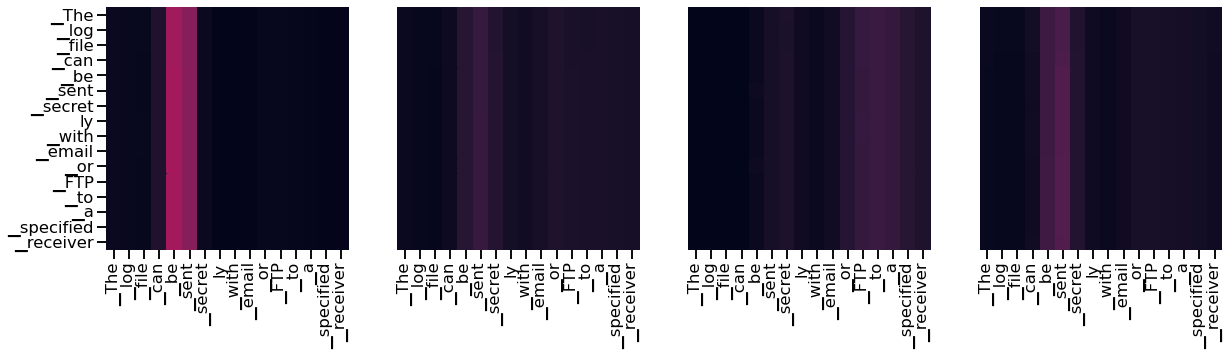

Encoder Layer 4


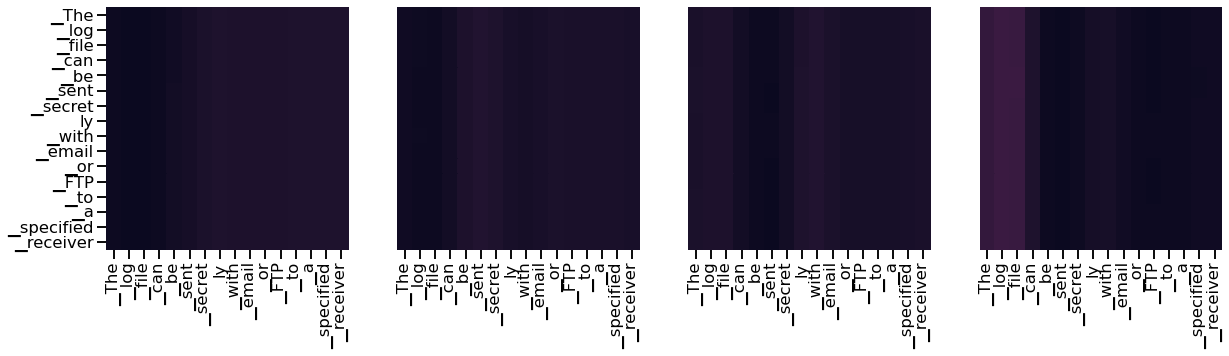

Encoder Layer 6


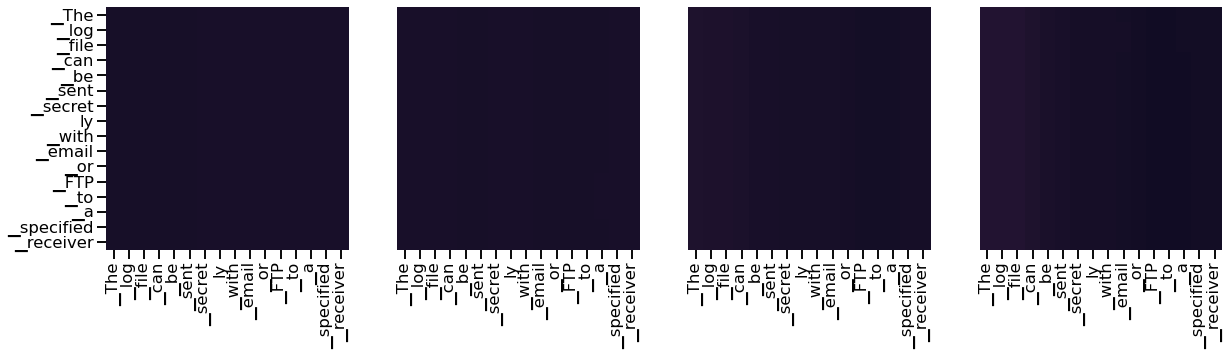

Decoder Self Layer 2


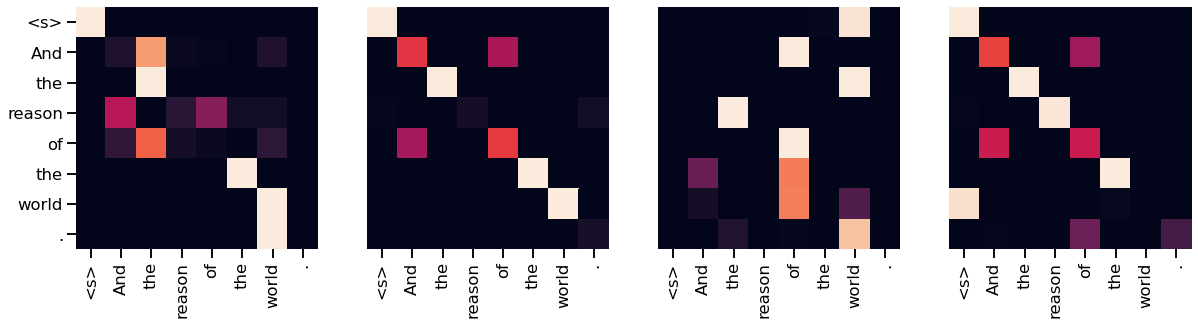

Decoder Src Layer 2


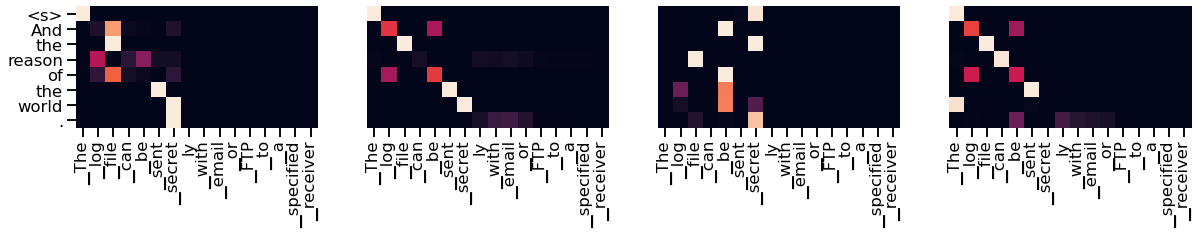

Decoder Self Layer 4


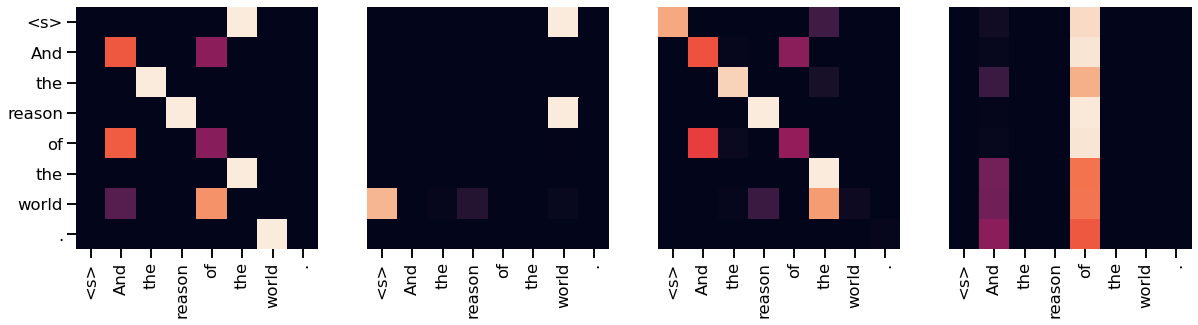

Decoder Src Layer 4


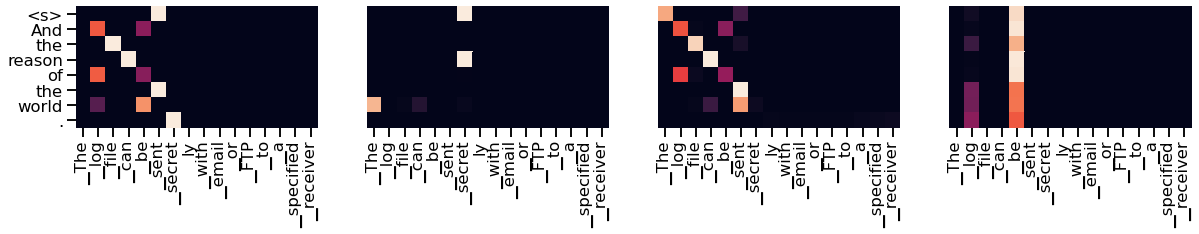

Decoder Self Layer 6


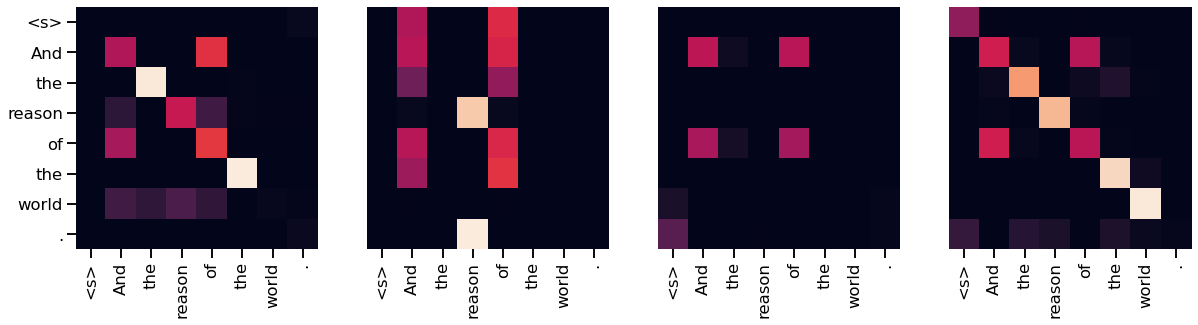

Decoder Src Layer 6


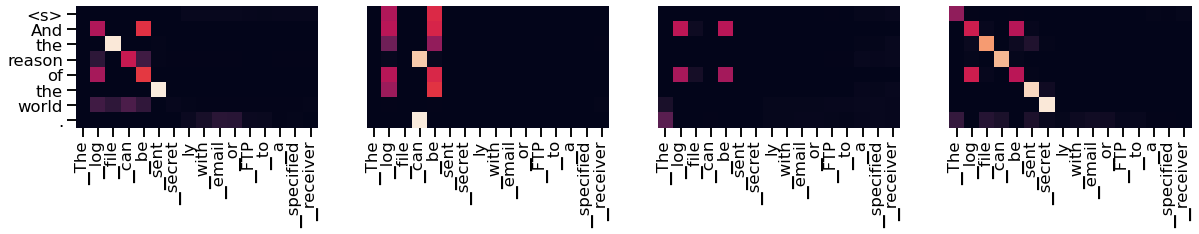

In [62]:
tgt_sent = trans.split()
def draw(data, x, y, ax):
    seaborn.heatmap(data, 
                    xticklabels=x, square=True, yticklabels=y, vmin=0.0, vmax=1.0, 
                    cbar=False, ax=ax)
    
for layer in range(1, 6, 2):
    fig, axs = plt.subplots(1,4, figsize=(20, 10))
    print("Encoder Layer", layer+1)
    for h in range(4):
        draw(model.encoder.layers[layer].self_attn.attn[0, h].data.cpu(), 
            sent, sent if h ==0 else [], ax=axs[h])
    plt.show()
    
for layer in range(1, 6, 2):
    fig, axs = plt.subplots(1,4, figsize=(20, 10))
    print("Decoder Self Layer", layer+1)
    for h in range(4):
        draw(model.decoder.layers[layer].self_attn.attn[0, h].data[:len(tgt_sent), :len(tgt_sent)].cpu(), 
            tgt_sent, tgt_sent if h ==0 else [], ax=axs[h])
    plt.show()
    print("Decoder Src Layer", layer+1)
    fig, axs = plt.subplots(1,4, figsize=(20, 10))
    for h in range(4):
        draw(model.decoder.layers[layer].self_attn.attn[0, h].data[:len(tgt_sent), :len(sent)].cpu(), 
            sent, tgt_sent if h ==0 else [], ax=axs[h])
    plt.show()

In [67]:
pre_model = torch.load('./transformer-ende-wmt-pyOnmt.tar/transformer-ende-wmt-pyOnmt/averaged-10-epoch.pt')

In [ ]:
model = make_model(len(SRC.vocab),len(TGT.vocab),N=6)
